# E-Health Lab: Diffusion Models 

By Sofi, Kaouther & Ricardo

Welcome to our introductory notebook to Diffusion models. Throughout this notebook, we will try to guide you to build and train your (maybe) first diffusion model! **$\color{yellow}{\text{How exciting}}$** ✨✨!!! 

After going through your very helpful and kind feedbacks, and after applying majority voting on your answers, we decided we will use  $\color{green}{\text{PyTorch}}$  as a framework and  $\color{green}{\text{X-Ray}}$ images as data for this activity. The data that we will use comes from RSNA Bone Age dataset from kaggle (https://www.kaggle.com/datasets/kmader/rsna-bone-age). The dataset is huge but don't worry! we downloaded it for you 👼!!

Below is an example image of the dataset:



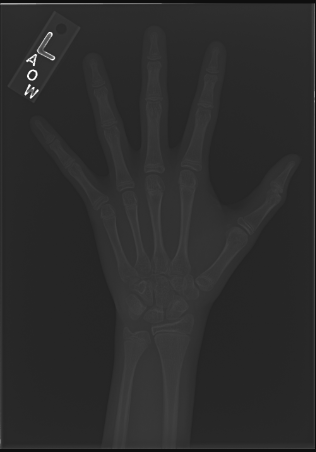

## 1- Packages

Here, we will import the necessary packages and libraries to run this notebook. Feel free to add any libraries that you need. 

In [ ]:
### General 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import math 
from pathlib import Path

### Pytorch
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torchvision import transforms 
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

## Pillow
from PIL import Image

### Other 
from traitlets.traitlets import validate

## 2- Parameters

Remember! It is a good practice to initialize parameters in one place so that it is easy to find them and change them. 

Feel free to come back here and put/update your parameters

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE = 64 # Image size
BATCH_SIZE = 32 # Batch size

T = 300 # Number of time stamps in the forward process

LR = 0.01

## 3- Prepare data

In this section, we will prepare the data needed for training our diffusion model.
The first step is to add a shortcut to the dataset folder in your google drive. Here is the link:
https://drive.google.com/drive/folders/1CDfgisYb8X43UpqP8qHxQPFDrmjVPMiq?usp=sharing


Next, mount Google drive to colab by running this code: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If done correctly, you should have the followings in your drive inside the bona_age_dataset folder: 
    
    - boneage-training-dataset: folder containing around 12k images 
    - boneage-test-dataset: folder containing 200 images 
    - boneage-training-dataset.csv: csv file that contains image ids of the training set (and other information that we don't need)
    - boneage-test-dataset: csv file that contains image ids of the test set

Check if everything went correctly! if not call us we got your code 💪! 

Now to the real PyTorching!! It is time to create our Dataset class. If you don't know what that is, here is the documentation link: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

It is basically a template for our dataset. We need to implement the following 3 methods: 
- \_\_init__ : the constructor 👷, it defines the actions to take when we first create a Dataset instance (object) 
- \_\_len__ : Simply returns the total number of images in the dataset 📏 
- \_\_getitem__ : It takes an index as argument and returns the image inside our dataset at that index 🤌 

Let's do it! 

In [ ]:
class RSNA(Dataset):
    """
    Dataset class for RSNA bone age X-Ray dataset
    Attributes: 
      img_ids (pd dataframe): dataframe containing image IDs 
      img_dir (Path): path to the images folder
      transform (optional): image preprocessing transform
    """
    def __init__(self, annotations_file: Path, img_dir: Path, transform=None):
        # the following lines will be executed when a RSNA object is created
        self.img_labels = pd.read_csv(annotations_file) # read the image ids and data as a pd dataframe
        self.img_dir = img_dir # set the image directory to the given img_dir path
        self.transform = transform # if given, set the transform for preprocessing the images 

    def __len__(self):
        return len(self.img_labels) # return the number of rows in our dataframe => each row represents an image

    def __getitem__(self, idx):
        # the following code will be executed when an image is requested from the dataset
        img_name = f'{self.img_labels.iloc[idx, 0]}.png' # get the image ID from the dataframe and add the image extension 
        img_path = str(self.img_dir / img_name) # create the image path by combining the dataset folder and image name 
        image = Image.open(img_path) # read the image using PIL
        if self.transform:
            image = self.transform(image) # if provided, apply preprocessing transform

        return image

Now that we have our class ready, we can create a RSNA object. Please make sure to provide the correct paths. 

In [ ]:
base_path = Path('./').resolve() # points to the home working directory (/content in Colab)
data_path = base_path / 'drive' / 'MyDrive' / 'bone_age_dataset' # path to the dataset folder, make sure to change it according to your folder names
annotation_file = data_path / 'boneage-training-dataset.csv' # this should point to the train CSV
image_dir = data_path / 'boneage-training-dataset' / 'boneage-training-dataset' # this should point to the folder where the images are stored

In [ ]:
rsna_train = RSNA(annotation_file, image_dir) # Instanciate the Dataset object 
print(f'Total #images: {len(rsna_train)}')

Total #images: 12611


The code should print the total number of images in our dataset. Now let's look at some of them.

In [ ]:
# Helper function to visualize some images from the dataset. 
def show_images(dataset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(num_samples/cols + 1, cols, i + 1)
        plt.imshow(np.asarray(img), cmap='gray')

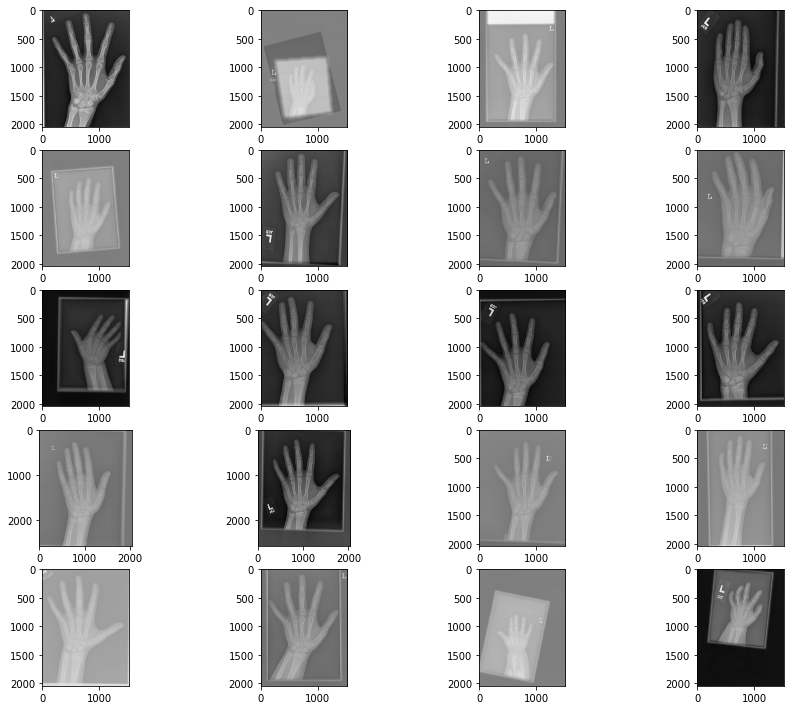

In [ ]:
show_images(rsna_train)

Taking a look at the images, we can see that they all have the same size ( $\color{green}{\text{Perfect!!}}$ 😃) BUT, the resolution is huge ($\color{red}{\text{Baaad!!}}$ 😭) so we will have to preprocess these images to a lower resolution (smaller size) to make it easier for our model (and for us!)... Also note that the images still need to be normalized to [-1, 1] and converted to a PyTorch tensor, their type now is a PIL image. How do we do that ?? 

Answer =>**$\color{green}{\text{PREPROCESSING TRANSFORMS!}}$** 

In [ ]:
# Create a preprocessing transform
data_transform = transforms.Compose( [transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), # Scales data into [0,1] 
                                      transforms.Lambda(lambda t: (t * 2) - 1)] # Scale between [-1, 1] 
                                    )


rsna_train = RSNA(annotation_file, image_dir, data_transform) # Instanciate the Dataset object 
print(f'Total #images: {len(rsna_train)}')

Total #images: 12611


Note that the previous function that we had only shows PIL images... We need a new function that can plot images stored in Tensors. You can use the following: 

In [ ]:
def show_tensor_image(image):
    # You need to reverse your preprocessing here.. otherwise you will only see black images !!
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image), cmap='gray')

Now, let's create a Dataloader (read more about it here https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) that will help us to iterate over our images in mini-batches. 

In [ ]:
train_loader = DataLoader(rsna_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Easy peasy !! now let's show some images 🙂

In [ ]:
batch = next(iter(train_loader)) # retrieve the first batch of data

In [ ]:
batch.shape

torch.Size([32, 1, 64, 64])

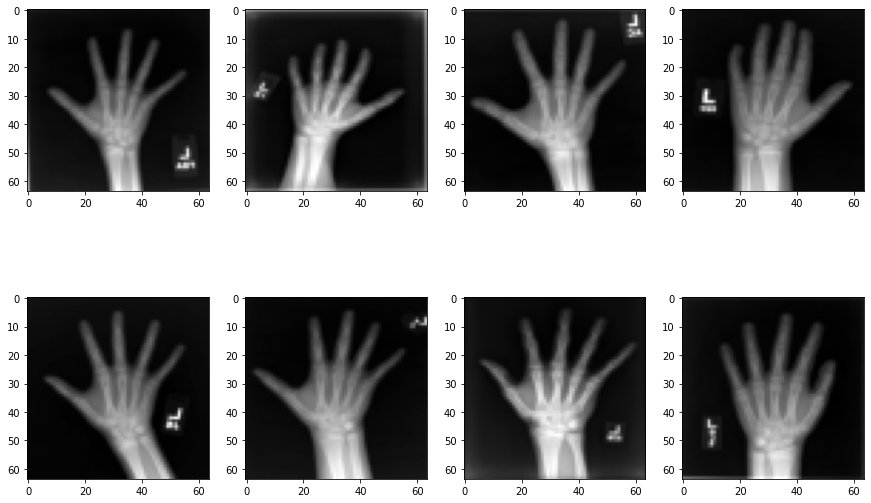

In [ ]:
num_samples=8
cols = 4
plt.figure(figsize=(15,15)) 
for i in range(BATCH_SIZE):
    if i == num_samples:
        break
    plt.subplot(num_samples/cols + 1, cols, i + 1)
    show_tensor_image(batch[i, :, :, :])

Well! If you had made it this far correctly... CONGRATS 👏👏👏👏! 

you have your dataset and your dataloader and you can jump right into the ocean of Diffusion Models 🌊 🌊 🌊 🌊! 

## 4- Forward process (Noise scheduler)

Remember from the theoretical part that the forward process consists of sequentially adding Gaussian noise to an image until we get a pure noise image. 

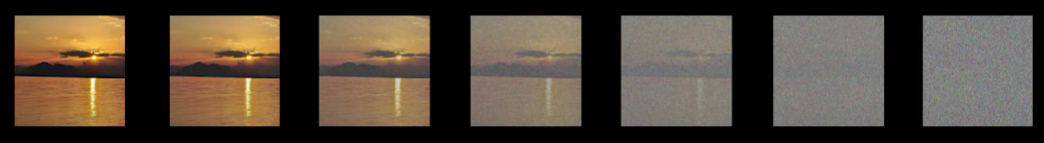


Also remember the following key points: 

*   Noise scheduling is a FIXED process. So, the variances (betas) for each timestep t can be precomputed.
*   There are different ways to do the noise scheduling
*   The sum of Gaussians is a Gaussian => instead of calculating the noisy images sequentially, we can do it in closed form sampling. 
*   Since the process is fixed, no neural network is needed


First, let us provide some useful functions that we will need later

In [ ]:
def get_value_from_list_by_idx(vals, t, x_shape):
    """ 
    Returns the value stored at a specific index t of a passed list of values vals
    while considering the batch dimension.
    Args:
      vals : list of values from which the value is returned 
      t : the position of the value to be returned in the list vals
      x_shape : the shape of the mini-batch 
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    val = out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
    return val

Let's create the variance scheduler functions. 

These functions will be used to generate a list of size n of variances (betas) following some pre-defined trend.

Here we will implement two noise schedulers: linear and cosine 

Linear: 

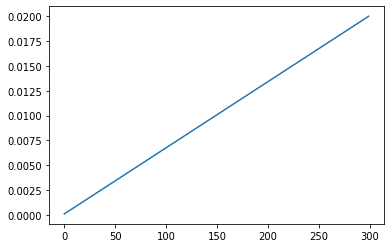

In [ ]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    linear scheduler that takes the number of time stamps (size of the tensor), the initial and final betas to generate a list of betas 
    """
    return torch.linspace(start, end, timesteps)

Cosine:


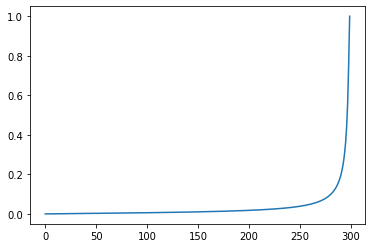

In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

Now, we can precompute some values that we will use in the forward process. 
Remember the following useful formulae:

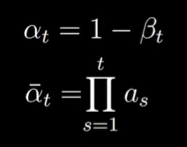

Let's compute these values..

In [ ]:
betas = linear_beta_schedule(timesteps=T)
alpha_ts = 1.0 - betas
alpha_ts_cumprod = torch.cumprod(alpha_ts, axis=0) 

Recall the closed form sampling formula:

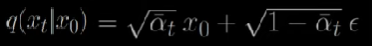

We need to calculate 2 more entities, square roots of alpha_ts_cumprod and of (1 - alpha_ts_cumprod)

In [ ]:
sqrt_alphas_cumprod = torch.sqrt(alpha_ts_cumprod)
sqrt_1_minus_alphas_cumprod = torch.sqrt(1.0 - alpha_ts_cumprod)

That's it! now we have everything to perform our forward process... let's create a function that takes an image and a time step as parameters then uses the values that we have just calculated to calculate the noisy version of the image at the specific time step t by applying the formula given above.

In [ ]:
def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    Args: 
      x_0 : original image 
      t   : timestep at which the noisy version is generated 
      device : device type 'cpu' or 'cuda'
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_value_from_list_by_idx(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_value_from_list_by_idx(
        sqrt_1_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

Now let's see if it works!

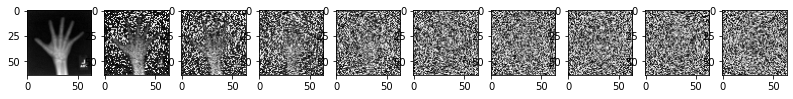

In [ ]:
image = batch[0]  # get the fisrt image of the batch that we previously saw

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10 # how many images we want to see 
stepsize = int(T/num_images) # step between two consecutive images we want to see

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64) # convert the index to a tensor
    plt.subplot(1, num_images+1, (idx/stepsize) + 1)
    image_n, noise = forward_diffusion_sample(image, t) # apply the forward process
    show_tensor_image(image_n)

That's it! DONE!!! ✨ ✨ ✨

## 5- Backward Process (U-Net)

Remember the following keypoints:
- In the forward process we use a U-Net (or any network architecture) to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- The result will be image - noise
- Because the parameters are shared accross time, we need to tell the network in which timestep we are => Time embedding (similar to positional imbedding in ViT)
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed 

The positional encoding of the transformer looks like this ... 



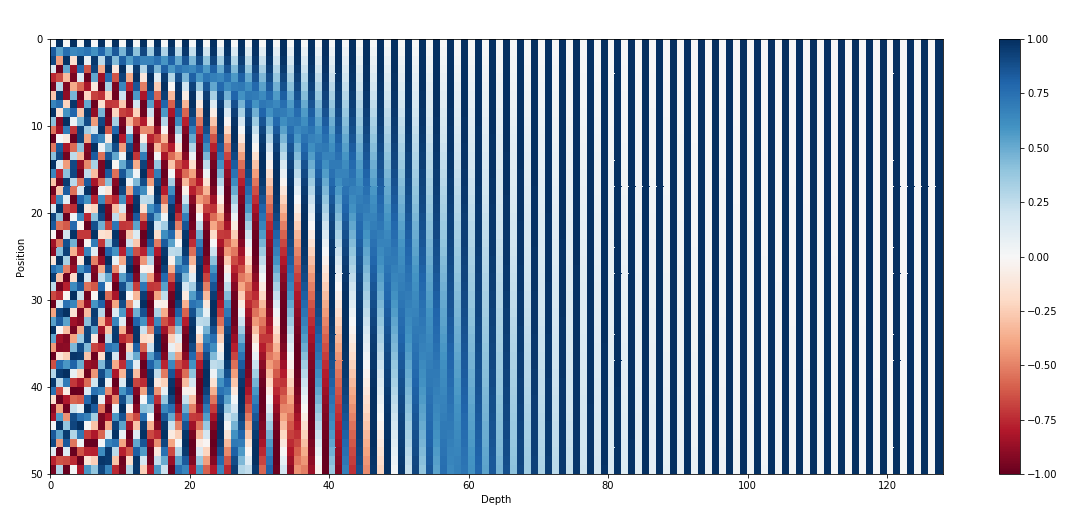

And it is given by: 


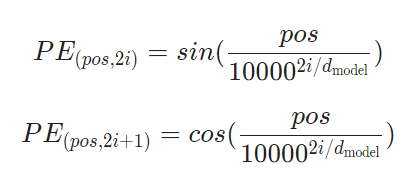

Don't worry if you don't understand... we don't understand either 😀 

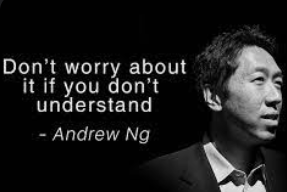

We will create a module that performs this step inside the network. Notice that this module has no learnable parameters... it will just be used as an additional channel to the input and features maps to tell the network about the time step we are currently at.

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

Next, we create our simple U-Net model, similar to the famous architecture that you can see below (Refer to Dr. Jose Bernal's seminar for more information about U-Net) 


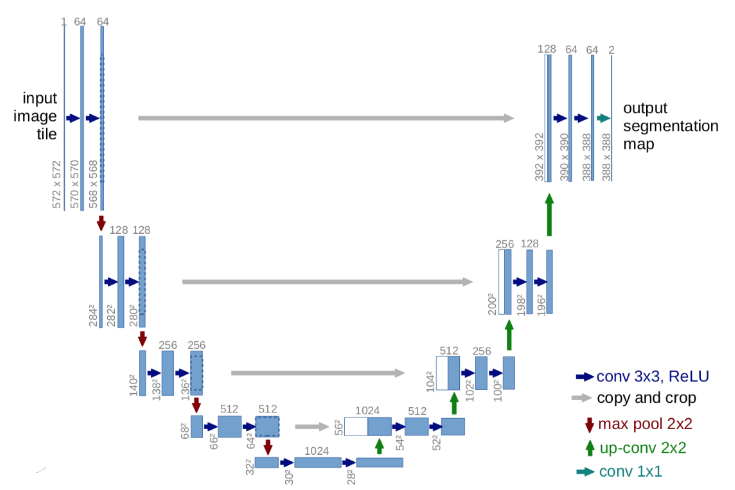

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        h = self.transform(h)
        return h

class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], image_channels, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [ ]:
# Create the model
model = SimpleUnet().to(DEVICE)

print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  62437601


Look, the number of parameters is **$\color{red}{\text{HUGE!!!}}$** 60 M for just a simple U-Net... this is why training Diffusion models take a lot of time and resources, and this is why they work very well... 


6- The loss

Now, with the easiest part, the loss ✨ ✨ ✨

Unlike the scary loss functions used to train GANs.. in Diffusion, the loss is simply the error (L1 norm, L2 norm...etc) between the real noise and the noise predicted by the model... $\color{green}{\text{EASYY}}$ and $\color{green}{\text{LOVELY}}$



In [ ]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, DEVICE)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## 6- Training 

Before we train our model, remember the following: 
- To train the model, we input a noisy image and the model should estimate the noise in that image. 
- To generate a new image, we input pure noise to the model, the model estimates the noise, we subtract the noise from the image, we input the result to the model and estimate again, and so on... until the image becomes pure...

In this phase, we will need to calculate more values to be used in the inference/training process

In [ ]:
alphas_cumprod_prev = F.pad(alpha_ts_cumprod[:-1], (1, 0), value=1.0) # alphas_(t-1)
sqrt_recip_alphas = torch.sqrt(1.0 / alpha_ts) # sqrt(1/alpha_)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alpha_ts_cumprod) 

First let's create some sampling functions

In [ ]:
@torch.no_grad() # make sure to use this one because otherwise u will get memory errors
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_value_from_list_by_idx(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_value_from_list_by_idx(sqrt_1_minus_alphas_cumprod, t, x.shape) 
    sqrt_recip_alphas_t = get_value_from_list_by_idx(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * ( x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_value_from_list_by_idx(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

In [ ]:
@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 1, img_size, img_size), device=DEVICE)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=DEVICE, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i/stepsize+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

Now, the moment of Truth... Let's train! 

In [ ]:
path = '/content/drive/MyDrive/bone_age_dataset/weights.pth'

Epoch 0 | step 000 Loss: 0.8101167678833008 


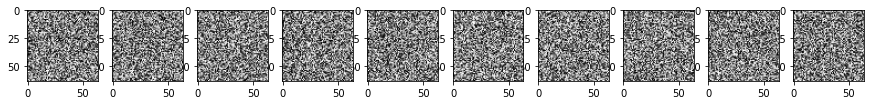

Epoch 5 | step 000 Loss: 0.11241922527551651 


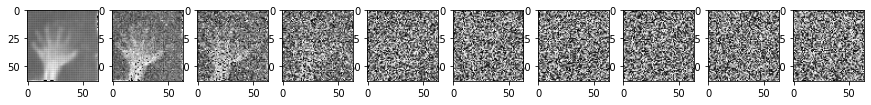

Epoch 10 | step 000 Loss: 0.08498869836330414 


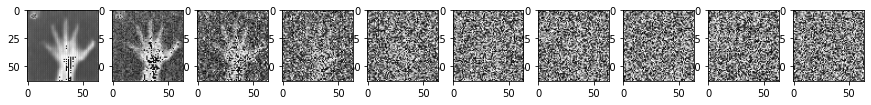

Epoch 15 | step 000 Loss: 0.07240307331085205 


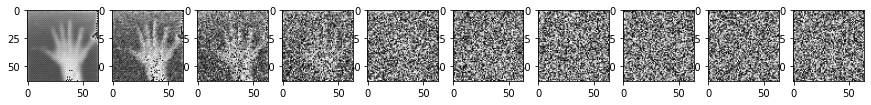

Epoch 20 | step 000 Loss: 0.09503066539764404 


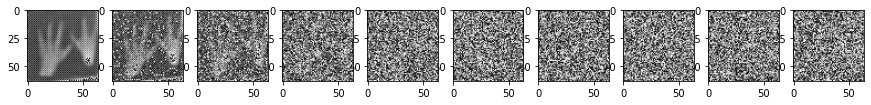

In [ ]:
optimizer = Adam(model.parameters(), lr=LR)
epochs = 50 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=DEVICE).long()
      loss = get_loss(model, batch, t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

    torch.save(model.state_dict(), path)

You can see that even at the 5th epoch, the model generations started to look like a hand! Well done model 👏 👏 👏 

but of course, the images we can get with this simple model and low resolution images are not plausible and not useable for training a real medical imaging network... but with the current resources, this is the best we can do 🤷🏻‍♂️🤷🏻‍♂️🤷🏻‍♂️



## 7- Inference

In [ ]:
path = '/content/drive/MyDrive/bone_age_dataset/weights.pth' # please change this to the path of the weights according to your file system
model = SimpleUnet().to(DEVICE)
model.load_state_dict(torch.load(path))
sample_plot_image()

Things you can do to improve these results: 
- Use a different beta scheduler (maybe make a network learn the betas too?) 
- Use a better model for the backward process 
- Add attention 
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization 
- GroupNormalization 
and many many more...

**$\color{green}{\text{Congratulations!!!}}$** you did it! you trained a diffusion model from scratch 🎉🎊✨